In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [28]:
dataset = pd.read_csv('Orçamentos.csv', delimiter=";")
dataset.head()

,EXERCÍCIO,NOME ÓRGÃO SUPERIOR,NOME ÓRGÃO SUBORDINADO,NOME UNIDADE ORÇAMENTÁRIA,NOME FUNÇÃO,NOME SUBFUNÇÃO,NOME PROGRAMA ORÇAMENTÁRIO,NOME AÇÃO,NOME CATEGORIA ECONÔMICA,NOME GRUPO DE DESPESA,NOME ELEMENTO DE DESPESA,ORÇAMENTO INICIAL (R$),ORÇAMENTO ATUALIZADO (R$),ORÇAMENTO EMPENHADO (R$),ORÇAMENTO REALIZADO (R$)
0,2021,Ministério da Educação,Universidade Federal de Santa Maria,UNIVERSIDADE FEDERAL DE SANTA MARIA,Educação,Formação de recursos humanos,PROGRAMA DE GESTAO E MANUTENCAO DO PODER EXECU...,CAPACITACAO DE SERVIDORES PUBLICOS FEDERAIS EM...,DESPESAS CORRENTES,Outras Despesas Correntes,Não informado,-6538800,0,0,0
1,2021,Ministério da Educação,Universidade Federal Fluminense,REC. SOB. SUPERV. UNIV. FED. FLUMINENSE,Educação,Formação de recursos humanos,PROGRAMA DE GESTAO E MANUTENCAO DO PODER EXECU...,CAPACITACAO DE SERVIDORES PUBLICOS FEDERAIS EM...,DESPESAS CORRENTES,Outras Despesas Correntes,Não informado,26118000,0,0,0
2,2021,Ministério da Educação,"Instituto Federal de Educação, Ciência e Tecno...",REC. SOB. SUP. INST. FED. RIO GRANDE DO NORTE,Educação,Formação de recursos humanos,PROGRAMA DE GESTAO E MANUTENCAO DO PODER EXECU...,CAPACITACAO DE SERVIDORES PUBLICOS FEDERAIS EM...,DESPESAS CORRENTES,Outras Despesas Correntes,Não informado,116800000,0,0,0
3,2021,Ministério da Educação,Fundação Universidade Federal de São João Del-Rei,RECURSOS SOB SUPERVISAO DA FUNDACAO UFSJ,Educação,Formação de recursos humanos,PROGRAMA DE GESTAO E MANUTENCAO DO PODER EXECU...,CAPACITACAO DE SERVIDORES PUBLICOS FEDERAIS EM...,DESPESAS CORRENTES,Outras Despesas Correntes,Não informado,13188900,0,0,0
4,2021,Ministério da Educação,Universidade Federal do Rio de Janeiro,REC. SOB. SUPERV. UNIV. FED. RIO DE JANEIRO,Educação,Formação de recursos humanos,PROGRAMA DE GESTAO E MANUTENCAO DO PODER EXECU...,CAPACITACAO DE SERVIDORES PUBLICOS FEDERAIS EM...,DESPESAS CORRENTES,Outras Despesas Correntes,Não informado,69261000,0,0,0


In [29]:
dataset_educacao = dataset[dataset['NOME ÓRGÃO SUPERIOR'] == 'Ministério da Educação']

Análise Macroeconômica (Orçamento Nominal x Orçamento Real)

In [30]:
orcamento_anual = dataset_educacao.loc[dataset_educacao['EXERCÍCIO'] <= 2024].groupby('EXERCÍCIO')['ORÇAMENTO ATUALIZADO (R$)'].sum()

In [31]:
orcamento_anual_bilhoes = orcamento_anual / 1_000_000_000_00

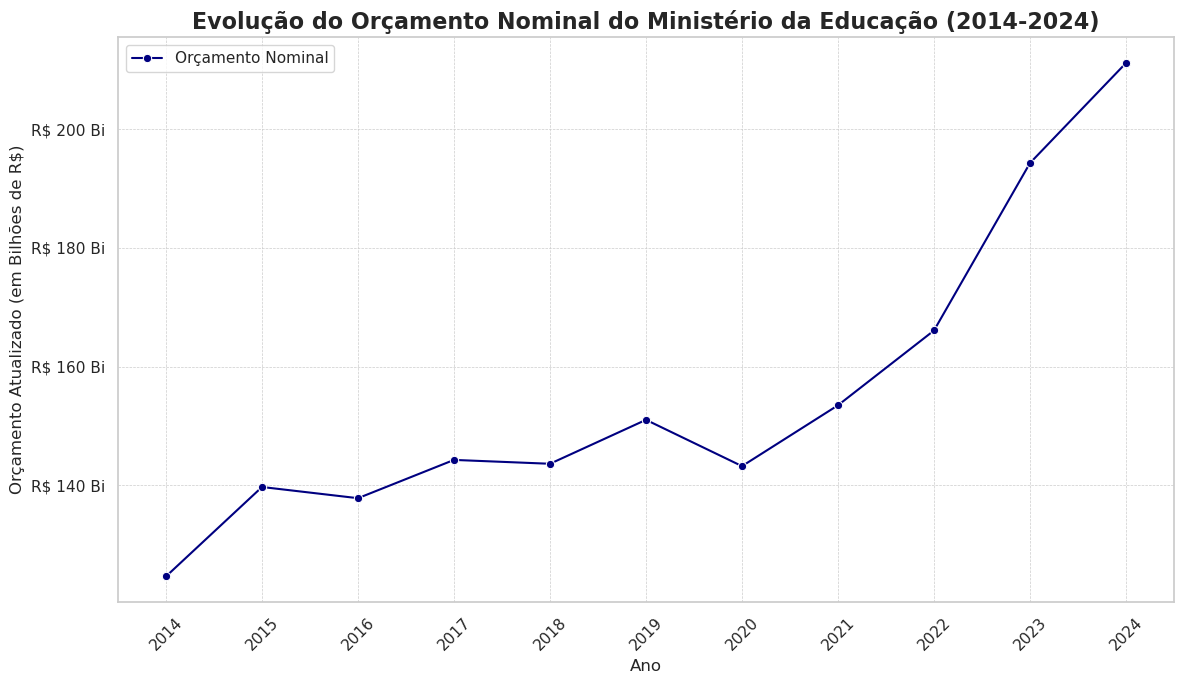

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

ax = sns.lineplot(x=orcamento_anual_bilhoes.index, y=orcamento_anual_bilhoes.values, marker='o', color='navy', label='Orçamento Nominal')

formatter = FuncFormatter(lambda y, _: f'R$ {y:.0f} Bi')
ax.yaxis.set_major_formatter(formatter)

plt.title('Evolução do Orçamento Nominal do Ministério da Educação (2014-2024)', fontsize=16, weight='bold')
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Orçamento Atualizado (em Bilhões de R$)', fontsize=12)
plt.xticks(orcamento_anual_bilhoes.index, rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
dados_ipca_anual = {
    'ano': [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'ipca_percentual': [6.41, 10.67, 6.29, 2.95, 3.75, 4.31, 4.52, 10.06, 5.79, 4.62, 4.83]
}

In [34]:
df_inflacao = pd.DataFrame(dados_ipca_anual)
df_inflacao['ipca_decimal'] = df_inflacao['ipca_percentual'] / 100

In [35]:
ano_base = 2024
df_inflacao = df_inflacao.set_index('ano')
df_inflacao['fator_correcao'] = 1.0

for ano in range(ano_base - 1, df_inflacao.index.min() - 1, -1):
    fator_proximo_ano = df_inflacao.loc[ano + 1, 'fator_correcao']
    inflacao_proximo_ano = df_inflacao.loc[ano + 1, 'ipca_decimal']
    df_inflacao.loc[ano, 'fator_correcao'] = fator_proximo_ano * (1 + inflacao_proximo_ano)

df_inflacao = df_inflacao.reset_index()

In [36]:
df_completo = pd.merge(orcamento_anual, df_inflacao, left_on='EXERCÍCIO', right_on='ano')

df_completo['ORÇAMENTO_REAL_2024'] = df_completo['ORÇAMENTO ATUALIZADO (R$)'] * df_completo['fator_correcao']

df_completo['ORÇAMENTO_REAL_BILHOES'] = df_completo['ORÇAMENTO_REAL_2024'] / 1_000_000_000_00
df_completo['ORÇAMENTO_NOMINAL_BILHOES'] = df_completo['ORÇAMENTO ATUALIZADO (R$)'] / 1_000_000_000_00

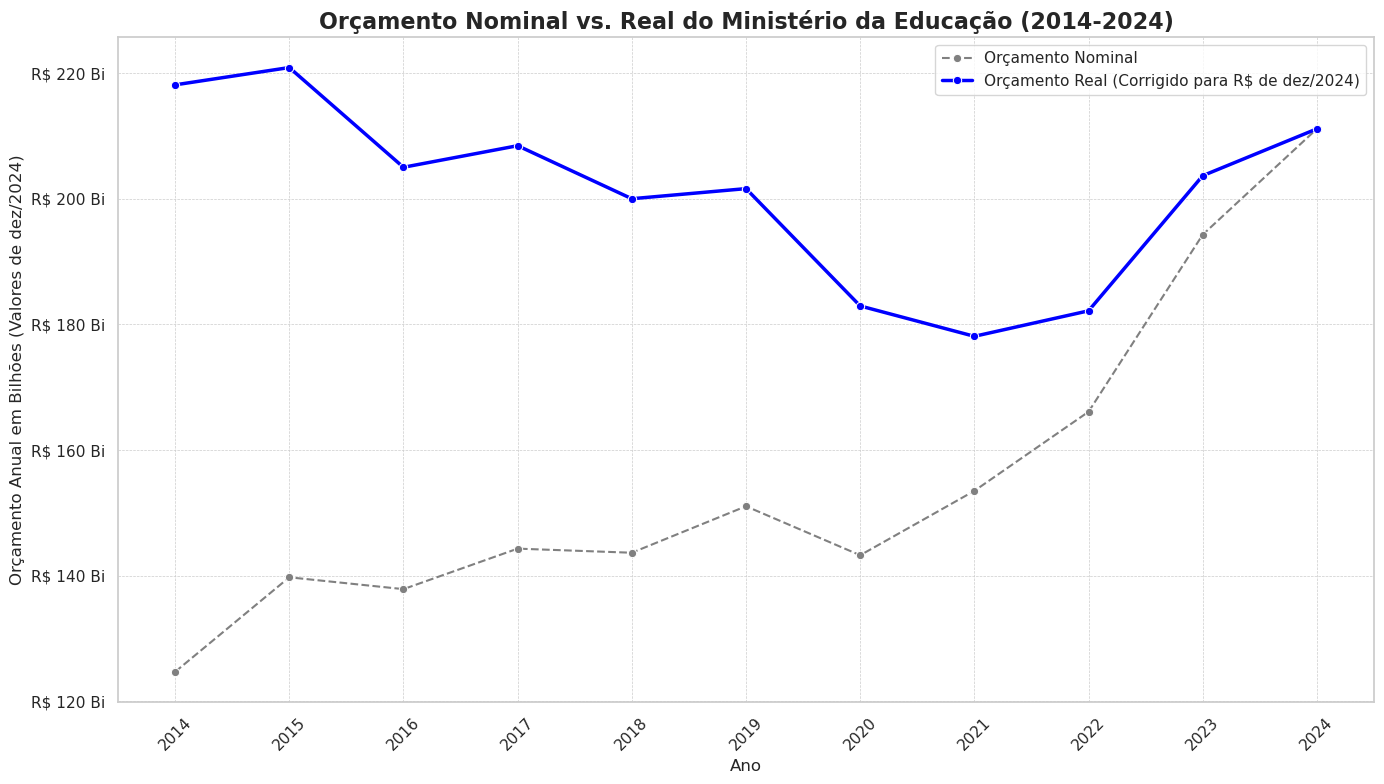

In [37]:
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

sns.lineplot(data=df_completo, x='ano', y='ORÇAMENTO_NOMINAL_BILHOES', marker='o', color='gray', linestyle='--', label='Orçamento Nominal')
sns.lineplot(data=df_completo, x='ano', y='ORÇAMENTO_REAL_BILHOES', marker='o', color='blue', linewidth=2.5, label='Orçamento Real (Corrigido para R$ de dez/2024)')

ax = plt.gca()
formatter = FuncFormatter(lambda y, _: f'R$ {y:.0f} Bi')
ax.yaxis.set_major_formatter(formatter)

plt.title('Orçamento Nominal vs. Real do Ministério da Educação (2014-2024)', fontsize=16, weight='bold')
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Orçamento Anual em Bilhões (Valores de dez/2024)', fontsize=12)
plt.xticks(df_completo['ano'].unique(), rotation=45)
plt.legend(fontsize=11)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Análise de Execução Orçamentária: Eficiência no Gasto

In [38]:
dataset_educacao = dataset[dataset['NOME ÓRGÃO SUPERIOR'] == 'Ministério da Educação'].copy()

dataset_educacao.loc[:, 'TAXA_EXECUCAO'] = (dataset_educacao['ORÇAMENTO REALIZADO (R$)'] / dataset_educacao['ORÇAMENTO ATUALIZADO (R$)']) * 100
dataset_educacao.loc[:, 'RESTOS_A_PAGAR'] = dataset_educacao['ORÇAMENTO EMPENHADO (R$)'] - dataset_educacao['ORÇAMENTO REALIZADO (R$)']

In [39]:
dataset_educacao.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset_educacao.fillna(0, inplace=True)

In [40]:
print("Colunas de eficiência calculadas. Exemplo das primeiras linhas:")
print(dataset_educacao[['EXERCÍCIO', 'ORÇAMENTO ATUALIZADO (R$)', 'ORÇAMENTO REALIZADO (R$)', 'TAXA_EXECUCAO', 'RESTOS_A_PAGAR']].tail())

Colunas de eficiência calculadas. Exemplo das primeiras linhas:
        EXERCÍCIO  ORÇAMENTO ATUALIZADO (R$)  ORÇAMENTO REALIZADO (R$)  \
310973       2022                  142077651                 142077651   
310974       2022                   50353671                  50353671   
310975       2022                    1672801                   1248538   
310976       2022                     557414                    112734   
310977       2022                   26149574                  24520095   

        TAXA_EXECUCAO  RESTOS_A_PAGAR  
310973     100.000000               0  
310974     100.000000               0  
310975      74.637569          424263  
310976      20.224465          444680  
310977      93.768621         1629479  


In [41]:
execucao_anual = dataset_educacao.loc[dataset_educacao['EXERCÍCIO'] <= 2024].groupby('EXERCÍCIO').agg({
    'ORÇAMENTO ATUALIZADO (R$)': 'sum',
    'ORÇAMENTO REALIZADO (R$)': 'sum'
})

execucao_anual['TAXA_EXECUCAO_GERAL'] = (execucao_anual['ORÇAMENTO REALIZADO (R$)'] / execucao_anual['ORÇAMENTO ATUALIZADO (R$)']) * 100


/tmp/ipykernel_5814/3303413190.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=execucao_anual.index, y=execucao_anual['TAXA_EXECUCAO_GERAL'], palette='viridis')


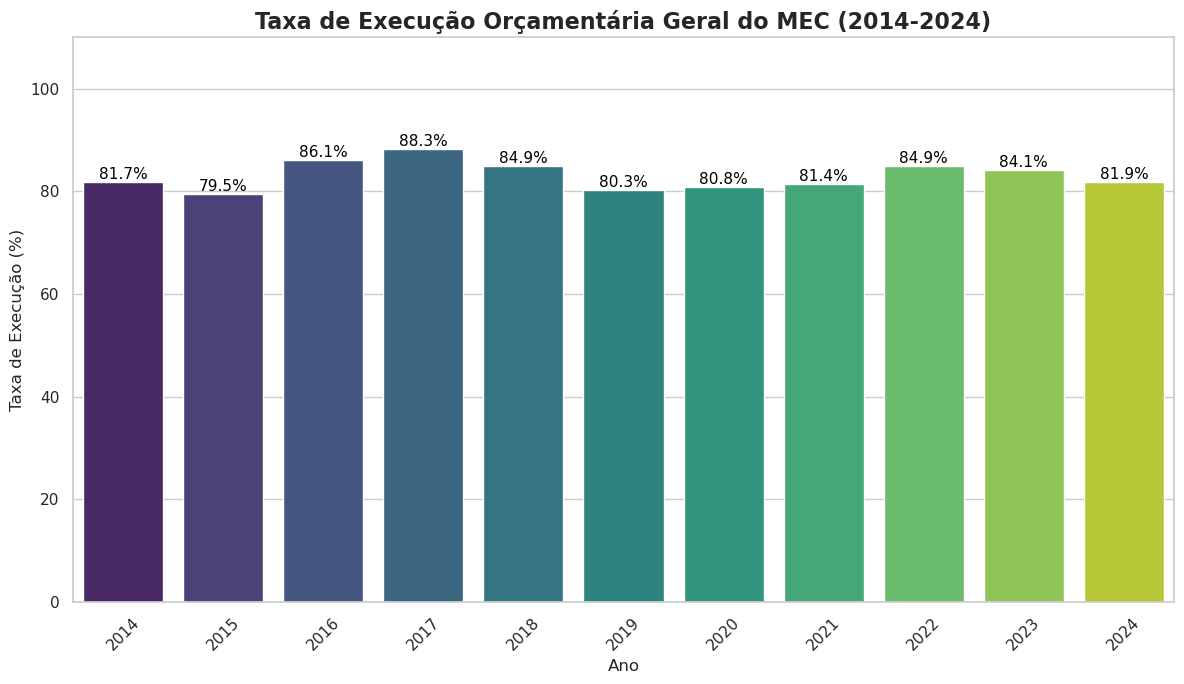

In [42]:
plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")

ax = sns.barplot(x=execucao_anual.index, y=execucao_anual['TAXA_EXECUCAO_GERAL'], palette='viridis')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=11, color='black')

plt.title('Taxa de Execução Orçamentária Geral do MEC (2014-2024)', fontsize=16, weight='bold')
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Taxa de Execução (%)', fontsize=12)
plt.ylim(0, 110)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

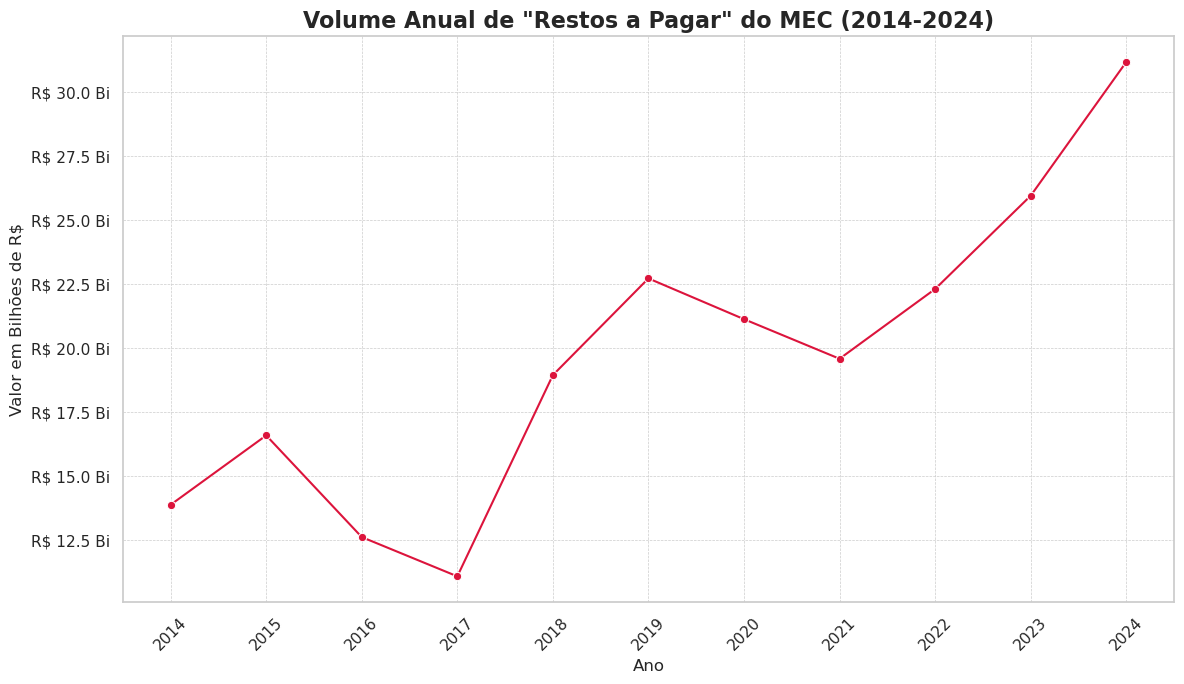

In [43]:
rap_anual = dataset_educacao.loc[dataset_educacao['EXERCÍCIO'] <= 2024].groupby('EXERCÍCIO')['RESTOS_A_PAGAR'].sum()

rap_anual_bilhoes = rap_anual / 1_000_000_000_00

plt.figure(figsize=(12, 7))

ax = sns.lineplot(x=rap_anual_bilhoes.index, y=rap_anual_bilhoes.values, marker='o', color='crimson')

formatter = FuncFormatter(lambda y, _: f'R$ {y:.1f} Bi')
ax.yaxis.set_major_formatter(formatter)

plt.title('Volume Anual de "Restos a Pagar" do MEC (2014-2024)', fontsize=16, weight='bold')
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Valor em Bilhões de R$', fontsize=12)
plt.xticks(rap_anual_bilhoes.index, rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Análise Comparativa: Quem são os Maiores e Mais Eficientes?

In [44]:
df_2024 = dataset_educacao[dataset_educacao['EXERCÍCIO'] == 2024].copy()
ranking_orcamento = df_2024.groupby('NOME ÓRGÃO SUBORDINADO')['ORÇAMENTO ATUALIZADO (R$)'].sum().sort_values(ascending=False)
ranking_orcamento_bilhoes = ranking_orcamento / 1_000_000_000_00

/tmp/ipykernel_5814/3024543869.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=ranking_orcamento_bilhoes.head(15).values, y=ranking_orcamento_bilhoes.head(15).index, palette='crest', orient='h')


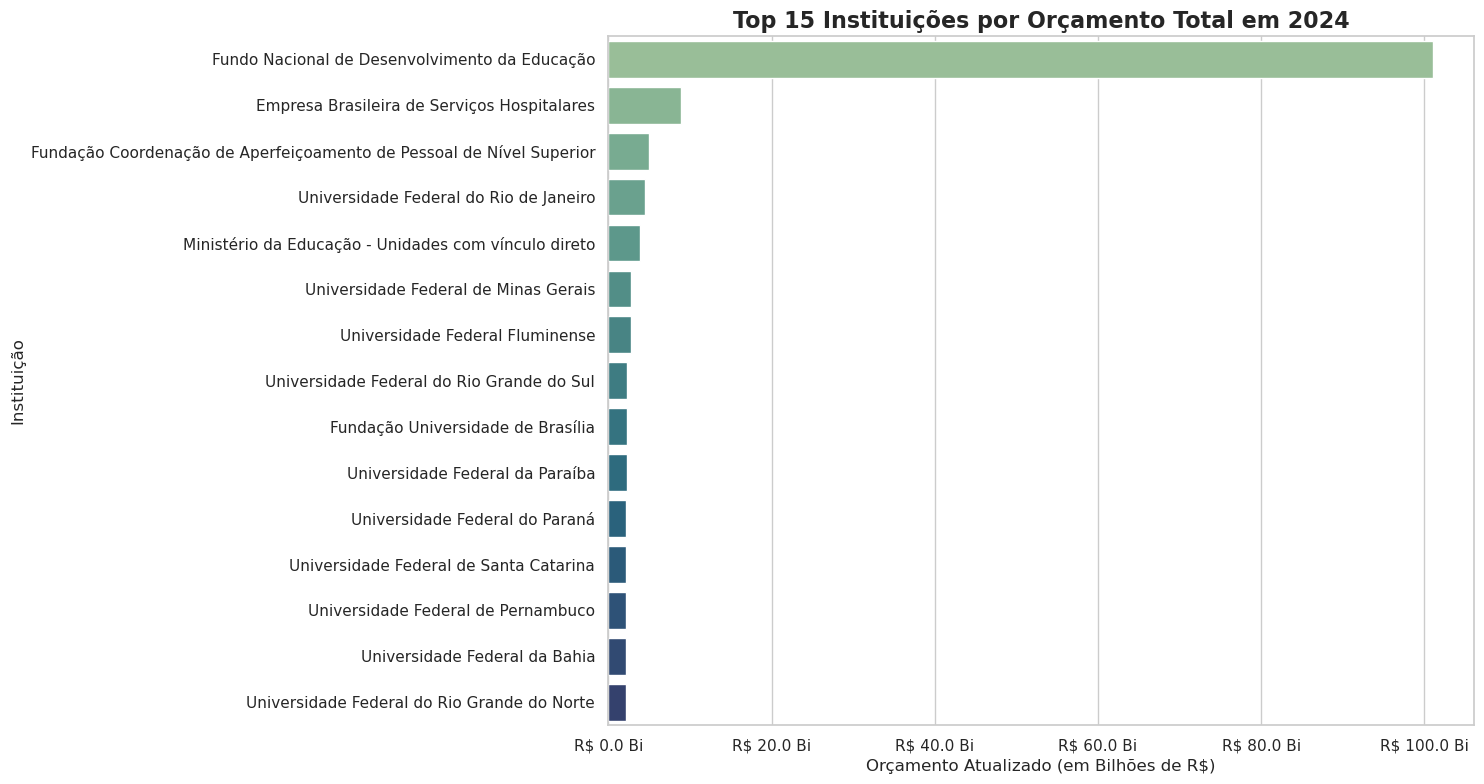

In [45]:
plt.figure(figsize=(15, 8))
sns.set_theme(style="whitegrid")

ax = sns.barplot(x=ranking_orcamento_bilhoes.head(15).values, y=ranking_orcamento_bilhoes.head(15).index, palette='crest', orient='h')

ax.set_title('Top 15 Instituições por Orçamento Total em 2024', fontsize=16, weight='bold')
ax.set_xlabel('Orçamento Atualizado (em Bilhões de R$)', fontsize=12)
ax.set_ylabel('Instituição', fontsize=12)

formatter = FuncFormatter(lambda x, _: f'R$ {x:,.1f} Bi')
ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

/tmp/ipykernel_5814/1218136055.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=ranking_eficiencia_final['TAXA_EXECUCAO_GERAL'].head(15).values, y=ranking_eficiencia_final.head(15).index, palette='plasma', orient='h')


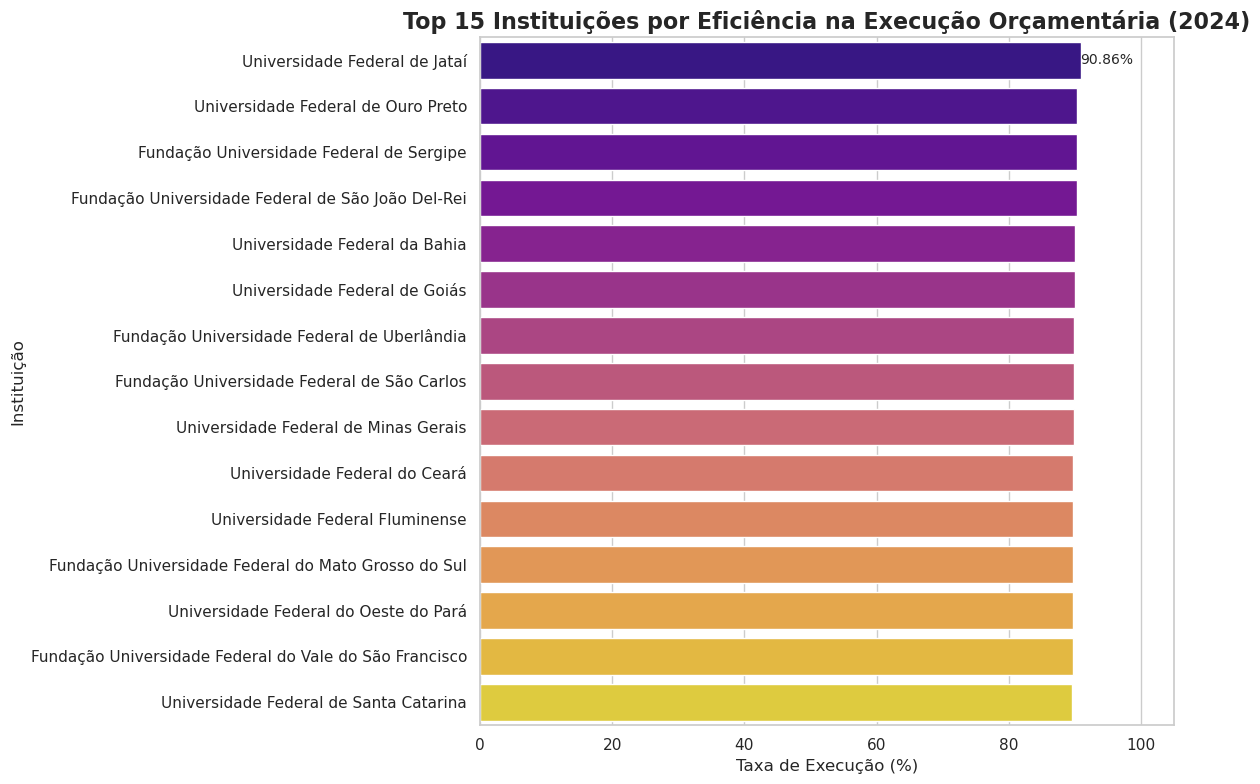

In [46]:
ranking_eficiencia = df_2024.groupby('NOME ÓRGÃO SUBORDINADO').agg({
    'ORÇAMENTO ATUALIZADO (R$)': 'sum',
    'ORÇAMENTO REALIZADO (R$)': 'sum'
})

ranking_eficiencia['TAXA_EXECUCAO_GERAL'] = (ranking_eficiencia['ORÇAMENTO REALIZADO (R$)'] / ranking_eficiencia['ORÇAMENTO ATUALIZADO (R$)']) * 100

orcamento_minimo = 10_000_000
ranking_eficiencia_filtrado = ranking_eficiencia[ranking_eficiencia['ORÇAMENTO ATUALIZADO (R$)'] > orcamento_minimo]

ranking_eficiencia_final = ranking_eficiencia_filtrado.sort_values(by='TAXA_EXECUCAO_GERAL', ascending=False)


plt.figure(figsize=(12, 8))

ax = sns.barplot(x=ranking_eficiencia_final['TAXA_EXECUCAO_GERAL'].head(15).values, y=ranking_eficiencia_final.head(15).index, palette='plasma', orient='h')

ax.set_title('Top 15 Instituições por Eficiência na Execução Orçamentária (2024)', fontsize=16, weight='bold')
ax.set_xlabel('Taxa de Execução (%)', fontsize=12)
ax.set_ylabel('Instituição', fontsize=12)

ax.bar_label(ax.containers[0], fmt='%.2f%%', fontsize=10)
ax.set_xlim(right=105)

plt.tight_layout()
plt.show()

/tmp/ipykernel_5814/3079381568.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(


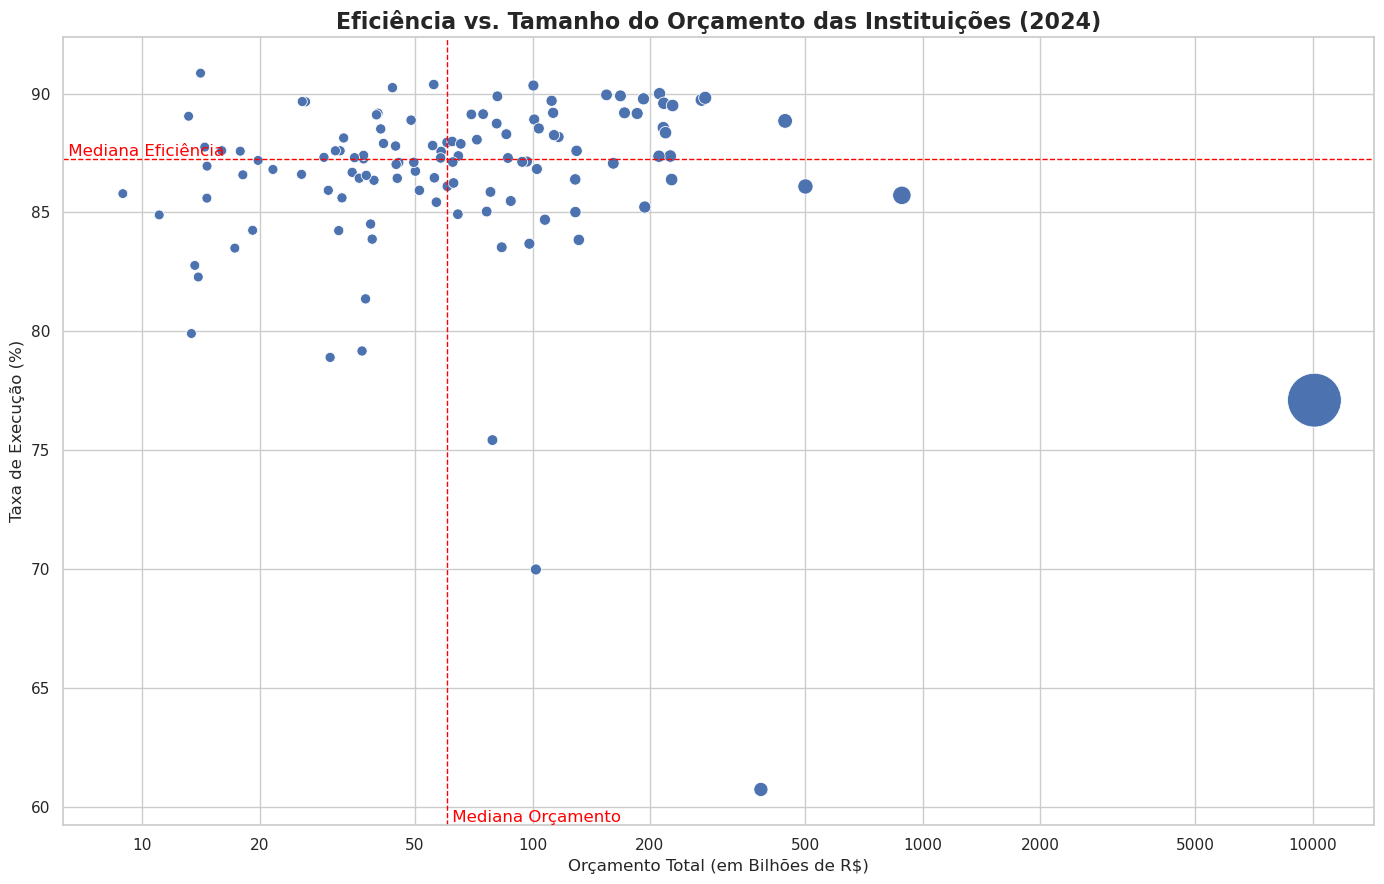

In [47]:
df_comparativo = ranking_eficiencia_filtrado.copy()
df_comparativo['ORÇAMENTO_BILHOES'] = df_comparativo['ORÇAMENTO ATUALIZADO (R$)'] / 1_000_000_000

plt.figure(figsize=(14, 9))

ax = sns.scatterplot(
    data=df_comparativo,
    x='ORÇAMENTO_BILHOES',
    y='TAXA_EXECUCAO_GERAL',
    size='ORÇAMENTO_BILHOES',
    sizes=(50, 1500),
    legend=False,
    palette='viridis'
)

media_orcamento = df_comparativo['ORÇAMENTO_BILHOES'].median()
media_eficiencia = df_comparativo['TAXA_EXECUCAO_GERAL'].median()

ax.axvline(media_orcamento, color='red', linestyle='--', lw=1)
ax.axhline(media_eficiencia, color='red', linestyle='--', lw=1)

plt.title('Eficiência vs. Tamanho do Orçamento das Instituições (2024)', fontsize=16, weight='bold')
plt.xlabel('Orçamento Total (em Bilhões de R$)', fontsize=12)
plt.ylabel('Taxa de Execução (%)', fontsize=12)

plt.xscale('log')

ax.xaxis.set_major_formatter(ScalarFormatter())

ticks = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
ax.set_xticks(ticks)

plt.text(media_orcamento, ax.get_ylim()[0], ' Mediana Orçamento', color='red', ha='left', va='bottom')
plt.text(ax.get_xlim()[0], media_eficiencia, ' Mediana Eficiência', color='red', ha='left', va='bottom')

plt.tight_layout()
plt.show()